# Turbo Engine Failure Prediction

#### Load Data and Libraries

In [6]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


train_data = pd.read_csv("train_FD001.csv", sep=";")
test_data = pd.read_csv("test_FD001_100ex.csv", sep=";")

lenYes = len([1 for v in train_data["Failure_status"] if v=="yes"])
lenNo = len([1 for v in train_data["Failure_status"] if v=="no"])
print(lenYes, lenNo, lenYes/(lenYes+lenNo))

3100 17531 0.15025931850128446


## Training

### Dimension Reduction

In [7]:
label_mapping = {"yes": 1,
                 "no": 0}

train_data["Failure_status"] = train_data["Failure_status"].map(label_mapping)
test_data["Failure_status"] = test_data["Failure_status"].map(label_mapping)

from sklearn.decomposition import PCA

x = train_data.iloc[:, :-1]
y = train_data.iloc[:, -1]

x_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

In [8]:
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()

x = stdScaler.fit_transform(x)
x_test = stdScaler.transform(x_test)

print(sum(pca.explained_variance_ratio_)) # with the previous PCA with just 2 components, only 65% of the variance is explained

from sklearn.decomposition import PCA

pca = PCA(n_components=0.9, svd_solver='full') # set PCA to explain 90% of the variance
x = pca.fit_transform(x)
x_test = pca.transform(x_test)
print(sum(pca.explained_variance_ratio_), x.shape[1]) # it takes 9 components to explain at least 90% of the variance

0.9693069120018645
0.9134299234365061 9


### SVM 

Models using support vector machine classifiers were tested. Three different models were trained, one using a linear kernel, another using a radial basis function kernel and a last one using a polynomial kernel.
All the three different models reproduced similar results with a validation accuracy of 96% and a test accuracy of 93%.

The following SVM parameters were tuned:
- C - Regularization parameter
- Gamma - Kernel coefficient for radial basis function and pollynomial
- Degree - Degree of the pollynomial kernel function

For the Linear kernel, 5-fold cross validation was used varing the C parameter. The best C parameter was 0.1.

In [11]:

print(svm.LinearSVC().get_params())
    
parameter_grid = [{
     
    "C":[0.001, 0.01, 0.1,1,10],
    "max_iter": [10000000]
    
}]

grid_search = GridSearchCV(svm.LinearSVC(), parameter_grid, cv=5, scoring="accuracy", verbose=4)
grid_search.fit(x,y)
  
results = pd.DataFrame(grid_search.cv_results_)
y_pred = grid_search.predict(x_test)

print("\nCrossvalidation statistics:")
results = results[["rank_test_score", "params", "mean_test_score", "std_test_score"]].sort_values("rank_test_score")
results = results.drop('params', axis=1).join(pd.DataFrame(results.params.values.tolist()))
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 1000)
display(results.style.hide_index())

print("Classifier performance for best parameters:")
print(classification_report(y_test, y_pred))

{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .....................C=0.001, max_iter=10000000; total time=   0.0s
[CV 2/5] END .....................C=0.001, max_iter=10000000; total time=   0.0s
[CV 3/5] END .....................C=0.001, max_iter=10000000; total time=   0.0s
[CV 4/5] END .....................C=0.001, max_iter=10000000; total time=   0.0s
[CV 5/5] END .....................C=0.001, max_iter=10000000; total time=   0.0s
[CV 1/5] END ......................C=0.01, max_iter=10000000; total time=   0.0s
[CV 2/5] END ......................C=0.01, max_iter=10000000; total time=   0.0s
[CV 3/5] END ......................C=0.01, max_iter=10000000; total time=   0.0s
[CV 4/5] END ......................C=0.01, max_iter=10000000; tot

rank_test_score,mean_test_score,std_test_score,C,max_iter
1,0.957927,0.007510,0.100000,10000000
2,0.957830,0.007548,1.000000,10000000
3,0.957781,0.007039,10.000000,10000000
4,0.957539,0.006860,0.001000,10000000
5,0.957151,0.006976,0.010000,10000000


Classifier performance for best parameters:
              precision    recall  f1-score   support

           0       0.91      1.00      0.96        75
           1       1.00      0.72      0.84        25

    accuracy                           0.93       100
   macro avg       0.96      0.86      0.90       100
weighted avg       0.94      0.93      0.93       100



For the radial basis function kernel, 5-fold cross validation was used varing the C and gamma parameters. The best C parameter was 10 and gamma was 100.

In [10]:
print(svm.SVC().get_params())
    
parameter_grid = [{
     
    "C":[ 0.001, 0.01, 0.1, 1, 10, 100],
    "gamma": [0.001, 0.01, 0.1, 1, 10, 100]
    
}]

grid_search = GridSearchCV(svm.SVC(), parameter_grid, cv=5, scoring="accuracy", verbose=4)
grid_search.fit(x,y)
  
results = pd.DataFrame(grid_search.cv_results_)
y_pred = grid_search.predict(x_test)

print("\nCrossvalidation statistics:")
results = results[["rank_test_score", "params", "mean_test_score", "std_test_score"]].sort_values("rank_test_score")
results = results.drop('params', axis=1).join(pd.DataFrame(results.params.values.tolist()))
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 1000)
display(results.style.hide_index())

print("Classifier performance for best parameters:")
print(classification_report(y_test, y_pred))

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END ...........................C=0.001, gamma=0.001; total time=   7.2s
[CV 2/5] END ...........................C=0.001, gamma=0.001; total time=   6.8s
[CV 3/5] END ...........................C=0.001, gamma=0.001; total time=   7.3s
[CV 4/5] END ...........................C=0.001, gamma=0.001; total time=   6.5s
[CV 5/5] END ...........................C=0.001, gamma=0.001; total time=   7.2s
[CV 1/5] END ............................C=0.001, gamma=0.01; total time=   7.8s
[CV 2/5] END ............................C=0.001, gamma=0.01; total time=   6.4s
[CV 3/5] END ............................C=0.001, gamma=0.01; total time=   6.0s
[CV 4/5] E

[CV 3/5] END ................................C=1, gamma=0.01; total time=   2.6s
[CV 4/5] END ................................C=1, gamma=0.01; total time=   2.5s
[CV 5/5] END ................................C=1, gamma=0.01; total time=   2.6s
[CV 1/5] END .................................C=1, gamma=0.1; total time=   3.2s
[CV 2/5] END .................................C=1, gamma=0.1; total time=   3.0s
[CV 3/5] END .................................C=1, gamma=0.1; total time=   3.0s
[CV 4/5] END .................................C=1, gamma=0.1; total time=   2.8s
[CV 5/5] END .................................C=1, gamma=0.1; total time=   3.0s
[CV 1/5] END ...................................C=1, gamma=1; total time=  29.5s
[CV 2/5] END ...................................C=1, gamma=1; total time=  30.9s
[CV 3/5] END ...................................C=1, gamma=1; total time=  30.3s
[CV 4/5] END ...................................C=1, gamma=1; total time=  30.5s
[CV 5/5] END ...............

rank_test_score,mean_test_score,std_test_score,C,gamma
1,0.960981,0.006216,10.000000,100.000000
2,0.960932,0.007102,1.000000,1.000000
3,0.960932,0.007155,0.100000,10.000000
4,0.960883,0.007525,0.001000,10.000000
5,0.960835,0.007626,0.001000,0.001000
6,0.960787,0.006024,0.001000,1.000000
7,0.960302,0.006720,100.000000,10.000000
8,0.959914,0.006579,100.000000,0.100000
9,0.959672,0.004983,0.010000,100.000000
10,0.959430,0.004875,10.000000,0.100000


Classifier performance for best parameters:
              precision    recall  f1-score   support

           0       0.91      1.00      0.96        75
           1       1.00      0.72      0.84        25

    accuracy                           0.93       100
   macro avg       0.96      0.86      0.90       100
weighted avg       0.94      0.93      0.93       100



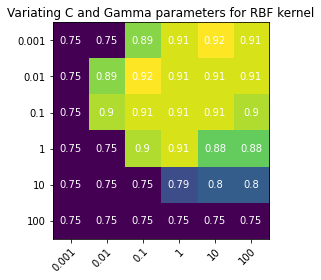

In [19]:



fig, ax = plt.subplots()
im = ax.imshow(np.reshape(scores, (len(g_c_parameters),len(g_c_parameters))))

# Setting the labels
ax.set_xticks(np.arange(len(g_c_parameters)))
ax.set_yticks(np.arange(len(g_c_parameters)))

# labeling respective list entries
ax.set_xticklabels(g_c_parameters)
ax.set_yticklabels(g_c_parameters)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


# Creating text annotations by using for loop
for g in range(len(g_c_parameters)):
    for c in range(len(g_c_parameters)):
        text = ax.text(g, c, np.reshape(scores, (len(g_c_parameters),len(g_c_parameters)))[c][g], ha="center", va="center", color="w")

ax.set_title("Variating C and Gamma parameters for RBF kernel")
fig.tight_layout()
plt.show()

For the polynomial kernel, 5-fold cross validation was used varing the degree of the polynomial kernel function. No more parameters were tuned because it would be too computational intensive.

In [9]:
parameter_grid = [{
     
    "kernel" :["poly"],
    "degree" : [2,3,4,5]
    
}]

grid_search = GridSearchCV(svm.SVC(), parameter_grid, cv=5, scoring="accuracy", verbose=4)
grid_search.fit(x,y)
  
results = pd.DataFrame(grid_search.cv_results_)
y_pred = grid_search.predict(x_test)

print("\nCrossvalidation statistics:")
results = results[["rank_test_score", "params", "mean_test_score", "std_test_score"]].sort_values("rank_test_score")
results = results.drop('params', axis=1).join(pd.DataFrame(results.params.values.tolist()))
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 1000)
display(results.style.hide_index())

print("Classifier performance for best parameters:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ..........................degree=2, kernel=poly; total time=   1.3s
[CV 2/5] END ..........................degree=2, kernel=poly; total time=   1.2s
[CV 3/5] END ..........................degree=2, kernel=poly; total time=   1.3s
[CV 4/5] END ..........................degree=2, kernel=poly; total time=   1.2s
[CV 5/5] END ..........................degree=2, kernel=poly; total time=   1.3s
[CV 1/5] END ..........................degree=3, kernel=poly; total time=   1.3s
[CV 2/5] END ..........................degree=3, kernel=poly; total time=   1.0s
[CV 3/5] END ..........................degree=3, kernel=poly; total time=   1.0s
[CV 4/5] END ..........................degree=3, kernel=poly; total time=   0.9s
[CV 5/5] END ..........................degree=3, kernel=poly; total time=   0.9s
[CV 1/5] END ..........................degree=4, kernel=poly; total time=   1.4s
[CV 2/5] END ..........................degree=4, 

rank_test_score,mean_test_score,std_test_score,degree,kernel
1,0.960835,0.006971,4,poly
2,0.959575,0.005692,2,poly
3,0.959284,0.005981,3,poly
4,0.957830,0.004903,5,poly


Classifier performance for best parameters:
              precision    recall  f1-score   support

           0       0.91      1.00      0.96        75
           1       1.00      0.72      0.84        25

    accuracy                           0.93       100
   macro avg       0.96      0.86      0.90       100
weighted avg       0.94      0.93      0.93       100

